# Predicting Review Helpfulness of Amazon Electronic Products
## Data Science Programming Spring 2020
## Darya Gahramanova

In [1]:
import numpy as np
import pandas as pd
import nltk
import string
import gensim
import re

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Embedding, Input, LSTM
from keras.models import Model
import tensorflow_hub as hub
tf.random.set_seed(42)

Using TensorFlow backend.


# Getting the Data

### Reading data and skipping erroneous lines

In [2]:
data=pd.read_csv('amazon_reviews_us_Electronics_v1_00.tsv', sep='\t', error_bad_lines=False, warn_bad_lines=False)
data.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,41409413,R2MTG1GCZLR2DK,B00428R89M,112201306,yoomall 5M Antenna WIFI RP-SMA Female to Male ...,Electronics,5,0,0,N,Y,Five Stars,As described.,2015-08-31
1,US,49668221,R2HBOEM8LE9928,B000068O48,734576678,"Hosa GPM-103 3.5mm TRS to 1/4"" TRS Adaptor",Electronics,5,0,0,N,Y,It works as advertising.,It works as advertising.,2015-08-31
2,US,12338275,R1P4RW1R9FDPEE,B000GGKOG8,614448099,Channel Master Titan 2 Antenna Preamplifier,Electronics,5,1,1,N,Y,Five Stars,Works pissa,2015-08-31
3,US,38487968,R1EBPM82ENI67M,B000NU4OTA,72265257,LIMTECH Wall charger + USB Hotsync & Charging ...,Electronics,1,0,0,N,Y,One Star,Did not work at all.,2015-08-31
4,US,23732619,R372S58V6D11AT,B00JOQIO6S,308169188,Skullcandy Air Raid Portable Bluetooth Speaker,Electronics,5,1,1,N,Y,Overall pleased with the item,Works well. Bass is somewhat lacking but is pr...,2015-08-31


In [3]:
data.shape

(3091024, 15)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3091024 entries, 0 to 3091023
Data columns (total 15 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   marketplace        object
 1   customer_id        int64 
 2   review_id          object
 3   product_id         object
 4   product_parent     int64 
 5   product_title      object
 6   product_category   object
 7   star_rating        int64 
 8   helpful_votes      int64 
 9   total_votes        int64 
 10  vine               object
 11  verified_purchase  object
 12  review_headline    object
 13  review_body        object
 14  review_date        object
dtypes: int64(5), object(10)
memory usage: 353.7+ MB


In [5]:
print(data['total_votes'].describe())

count    3.091024e+06
mean     2.372440e+00
std      2.249700e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      1.294400e+04
Name: total_votes, dtype: float64


Text(0, 0.5, 'Review Count')

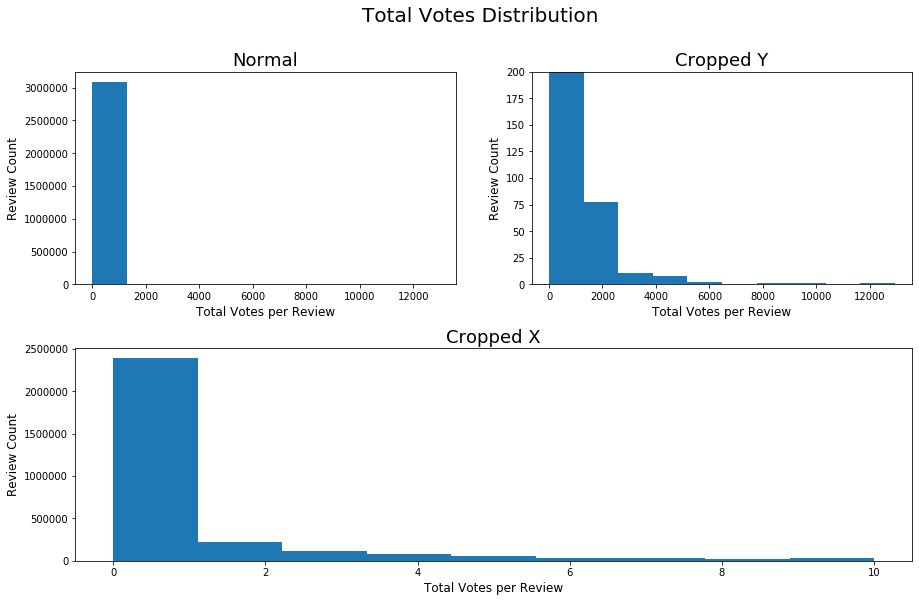

In [6]:
plt.figure(figsize=(15, 9))
plt.suptitle('Total Votes Distribution', fontsize=20)
plt.subplots_adjust(hspace=0.3)

plt.subplot(221)
plt.hist(data['total_votes'])
plt.title('Normal', fontsize=18)
plt.xlabel('Total Votes per Review', fontsize=12)
plt.ylabel('Review Count', fontsize=12)

plt.subplot(222)
plt.hist(data['total_votes'])
plt.ylim([0, 200])
plt.title('Cropped Y', fontsize=18)
plt.xlabel('Total Votes per Review', fontsize=12)
plt.ylabel('Review Count', fontsize=12)

bins = np.linspace(0, 10, 10)
plt.subplot(212)
plt.hist(data['total_votes'], bins)
plt.title('Cropped X', fontsize=18)
plt.xlabel('Total Votes per Review', fontsize=12)
plt.ylabel('Review Count', fontsize=12)

### Selecting reviews with 7 votes or more and from the US

In [7]:
new_data = data[data['marketplace'] == 'US']
new_data = new_data[new_data['total_votes'] >= 7]

print(len(data))
print(len(new_data))

3091024
203310


### Calculating review scores based on helpfulness (helpful votes out of total votes) and popularity (helpful votes per review among helpful votes per product) by using weighted average

In [8]:
total_helpful_votes = new_data.groupby(['product_id'],sort=False,as_index=False)['helpful_votes'].sum()
new_data = pd.merge(new_data,total_helpful_votes,on='product_id',how='left')
new_data.columns = new_data.columns.str.replace("helpful_votes_x","helpful_votes").str.replace("helpful_votes_y","total_helpful_votes")
new_data['helpfulness']=new_data['helpful_votes']/new_data['total_votes']
new_data['popularity']=new_data['helpful_votes']/new_data['total_helpful_votes']
new_data['score_continious'] = 0.7*new_data['helpfulness'] + 0.3*new_data['popularity']

### Converting scores to binary (0-unhelpful, 1-helpful) and dropping reviews with ambiguous scores (close to 0.5)

In [9]:
new_data['score_binary'] = pd.cut(new_data['score_continious'], bins=[0,0.3,0.7,1], labels=[0,2,1])
new_data.dropna(inplace=True)
new_data['score_binary'] = new_data['score_binary'].astype(int)
new_data = new_data[new_data['score_binary'] != 2]
new_data.describe()

,customer_id,product_parent,star_rating,helpful_votes,total_votes,total_helpful_votes,helpfulness,popularity,score_continious,score_binary
count,9.468500e+04,9.468500e+04,94685.000000,94685.000000,94685.000000,94685.000000,94685.000000,94685.000000,94685.000000,94685.000000
mean,3.409019e+07,5.045238e+08,3.533844,27.118878,31.860664,524.388974,0.786669,0.323144,0.647612,0.770808
std,1.499615e+07,2.877404e+08,1.610900,112.317610,116.245660,2033.433978,0.320074,0.346000,0.279271,0.420315
min,1.019000e+04,3.034600e+04,1.000000,1.000000,7.000000,2.000000,0.004878,0.000023,0.005769,0.000000
25%,2.000568e+07,2.545690e+08,2.000000,7.000000,9.000000,28.000000,0.750000,0.024938,0.701287,1.000000
50%,3.639575e+07,5.029799e+08,4.000000,10.000000,13.000000,96.000000,0.956522,0.198925,0.731788,1.000000
75%,4.908556e+07,7.589189e+08,5.000000,19.000000,25.000000,356.000000,1.000000,0.500000,0.809091,1.000000
max,5.309658e+07,9.999911e+08,5.000000,12786.000000,12944.000000,43090.000000,1.000000,1.000000,1.000000,1.000000


### The least helpful reviews

In [10]:
for row in new_data[new_data['helpfulness']<0.01]['review_body']:
    print(row+'\n*********')

to expensive
*********
Don't buy their cancellation headphones until they reverse the cancellation of the movie.It is time to show that we are not defined by September 11th. If we are defined by a date it is July 4th.  It means we will not be defined by fear. We are defined by our beliefs, and we believe in free speech.  We intend to see The Interview in the theater. We in Washington intend to see it legally stoned and laugh our asses off.
*********
Why on earth would they charge so much for a headset with a cord? Any gamer knows that the issue with a gaming headset is running over the cord and damaging the connection, which renders the headset (that is expensive) completely useless.<br /><br />The reviews state that the sound is incredible. I have to agree, but thats not the issue.<br /><br />You would think that if they were putting so much R&D into this item, they would have gone the extra mile.
*********
you should never get head aches from watching TRUE 3D at all. its the converti

### The longest review

In [62]:
maxlen=-1
for doc in new_data["review_body"]:
    if maxlen<len(doc):
        maxlen=len(doc)
        maxdoc=doc
print('Length:',maxlen)
print(maxdoc[:2000])

Length: 50610
This review is for: CyberPower PR750LCD 525W UPS<br /><br />OVERVIEW:<br />-----------<br /><br />The home and small office UPS models we'll compare are:<br /><br />- APC: SMT750, SMT1000<br />- APC: SMC1000, SMC1500<br />- CyberPower: CP850PFCLCD, CP1000PFCLCD, CP1350PFCLCD<br />- CyberPower: PR750LCD, PR1000LCD, PR1500LCD<br /><br />These all:<br /><br />(A) KEEP ELECTRICITY GOING DURING A BLACKOUT and give a computer TIME TO SAFELY AUTO-SHUTDOWN.<br /><br />(B) Produce a PURE SINE WAVE to work with power supplies with Active PFC, like those on most Apple Macs, lots of newer windows PCs, etc.<br /><br />(C) Cost in the low hundreds, so we avoid server room type features like zero transfer time, external batteries, etc.<br /><br />We'll compare:<br />- How long things run during a blackout (RUNTIME)<br />- The WATTS they handle<br />- NOISE<br />- OUTLET COUNT and how many have battery power<br /><br />We'll also compare:<br />- AVR CAPABILITY including BOOST and TRIM (e

### Score vs. length of the reviews

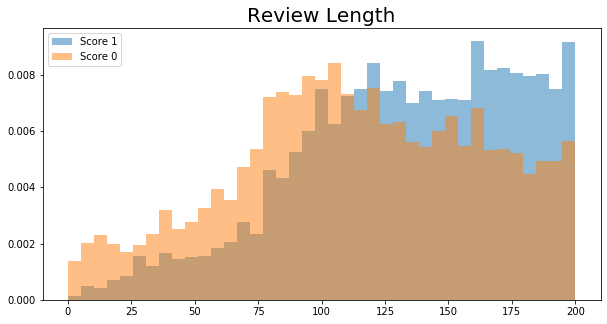

In [12]:
new_data['body_len'] = new_data.loc[:,'review_body'].apply(lambda x: len(str(x)) - str(x).count(" "))

bins = np.linspace(0, 200, 40)
plt.figure(figsize=(10, 5))
plt.hist(new_data[new_data['score_binary']==1]['body_len'], bins, alpha=0.5, normed=True, label='Score 1')
plt.hist(new_data[new_data['score_binary']==0]['body_len'], bins, alpha=0.5, normed=True, label='Score 0')
plt.legend(loc='upper left')
plt.title('Review Length', fontsize=20)
plt.show()

### Review score vs. star rating given by the reviewer

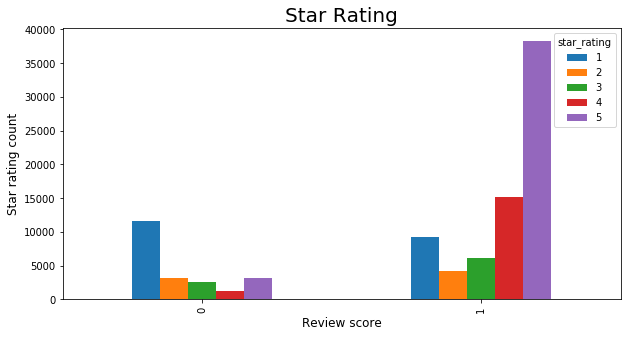

In [13]:
new_data.groupby('score_binary')['star_rating'].value_counts().unstack(level=1).plot.bar(figsize=(10,5))
plt.ylabel('Star rating count', fontsize=12)
plt.xlabel('Review score', fontsize=12)
plt.title('Star Rating', fontsize=20)
plt.show()

### Selecting a random subset of 15,000 reviews per each score

In [14]:
reviews = new_data[['review_body','score_binary']]

r1=reviews[reviews['score_binary']==0].sample(n=15000, random_state=16)
r2=reviews[reviews['score_binary']==1].sample(n=15000, random_state=16)
reviews = pd.concat([r1,r2], ignore_index=True,axis=0)

# Text Preprocessing

### Selecting stopwords

In [15]:
stopwords = nltk.corpus.stopwords.words('english')
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [16]:
stop = ['am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 
        'doing', 'a', 'an', 'the', 'and', 'to', 'of', 'at', 'for', 'by', 's', 't', 'will', 'would', 'wo', 'd', 'll', 'm',
        'o', 're', 've', 'y', 'to', 'ai', '']

### Cleaning text

In [17]:
def clean_text(text):
    text = re.sub('<.*?>', ' ', text)
    text = re.sub('&#34;', ' ', text)
    text = re.sub("n't ", ' not ', text)
    text = re.sub("n' ", ' not' , text)
    text = re.sub(" ca ", ' can ', text)
    text = re.sub('\d+', ' 0 ', text)
    text = re.sub('[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]', ' ', text)
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = " ".join([word for word in tokens if word not in stop])
    return text

In [18]:
review = reviews.review_body.iloc[0]
print(review)
print('*****')
review = clean_text(review)
print(review)

Havent purchased a set yet, but I read the reviews while trying to decide on whether or not to take a chance. Knowing you only get what you pay for these are my real world thoughts that i think will help others considering these speakers.<br /><br />1. Bass output has a direct relashoship to the wieght of the speaker. The speakers vibrates to make sound as the cone moves back and forth. A light speaker will move and vibrate in a way that takes energy away from the movement of the cone thus affecting bass output. The specs on these speakers say they are 55lbs, divide that by 5 speakers and no speaker will weight more than 15 or so pounds including the floor standing speakers. With that said this isnt a set up for loud bass heavy music.<br /><br />2. these are 6ohm speakers with means they have less resistance to an electrical input. One reviewer said you have to change your reciever to accomondate the 6ohm load. Most recievers dont have the capability to change the load on a set of spea

In [19]:
reviews['review_body'] = reviews['review_body'].apply(lambda x: clean_text(str(x)))

### Stemming cleaned text in a separate column

In [20]:
ps = nltk.PorterStemmer()

def stem_cleaned_text(text):
    tokens = text.split()
    text = " ".join([ps.stem(word) for word in tokens])
    return text

In [21]:
reviews['review_body_stemmed'] = reviews['review_body'].apply(lambda x: stem_cleaned_text(str(x)))

### Finding and merging important collocations in a separate column

In [22]:
split = reviews['review_body'].apply(lambda x: x.split())
unlist_reviews = [item for items in split for item in items]

blacklist = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 
             'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their',
             'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', '0']

from nltk.collocations import BigramCollocationFinder 
from nltk.metrics import BigramAssocMeasures 
bigram_measures = nltk.collocations.BigramAssocMeasures()

biagram_collocation = BigramCollocationFinder.from_words(unlist_reviews)
biagram_collocation.apply_word_filter(lambda w: w in blacklist)
colls = biagram_collocation.nbest(BigramAssocMeasures.likelihood_ratio, 300)
print(colls)

[('sound', 'quality'), ('asin', 'b'), ('better', 'than'), ('as', 'well'), ('customer', 'service'), ('there', 'no'), ('more', 'than'), ('battery', 'life'), ('can', 'not'), ('home', 'theater'), ('blu', 'ray'), ('set', 'up'), ('not', 'work'), ('less', 'than'), ('cd', 'player'), ('comes', 'with'), ('highly', 'recommend'), ('make', 'sure'), ('could', 'not'), ('so', 'far'), ('much', 'better'), ('very', 'good'), ('ear', 'buds'), ('happy', 'with'), ('high', 'end'), ('such', 'as'), ('alarm', 'clock'), ('even', 'though'), ('built', 'in'), ('build', 'quality'), ('remote', 'control'), ('noise', 'cancelling'), ('surge', 'protector'), ('living', 'room'), ('surround', 'sound'), ('based', 'on'), ('too', 'much'), ('stopped', 'working'), ('easy', 'use'), ('more', 'expensive'), ('dvd', 'player'), ('bottom', 'line'), ('come', 'with'), ('hard', 'drive'), ('ended', 'up'), ('very', 'happy'), ('usb', 'port'), ('figure', 'out'), ('not', 'know'), ('year', 'old'), ('rather', 'than'), ('pick', 'up'), ('years', 'a

In [23]:
def apply_collocations(text, colls):
    for c1, c2 in colls:
        text = text.replace("%s %s" % (c1, c2), "%s_%s" % (c1, c2))
    return text

reviews['review_body_collocations'] = reviews['review_body'].apply(lambda x: apply_collocations(x, colls))

In [24]:
print(reviews.review_body.iloc[4])
print('*****')
print(reviews.review_body_collocations.iloc[4])

ordered roku box linksys router bluerigger premium hdmi cable needed all 0 hook up work received roku box linksys router within 0 days not receive cable 0 days later could not use system wait i reccomend better shipping method because this not good
*****
ordered roku box linksys router bluerigger premium hdmi_cable needed all 0 hook_up work received roku box linksys router within 0 days not receive cable 0 days later could_not use system wait i reccomend better shipping method because this not good


# Train Test Split

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(reviews[['review_body','review_body_stemmed','review_body_collocations']],
                                                    reviews['score_binary'], stratify=reviews['score_binary'],
                                                    test_size=0.2, random_state=16)

In [26]:
print(X_train.shape)
print(X_test.shape)

(24000, 3)
(6000, 3)


# TF-IDF Vectorizer

### TF-IDF + SVD on Text

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

tfidf_vect = TfidfVectorizer(ngram_range=(1,1), max_features=10000)
tfidf_vect_fit = tfidf_vect.fit(X_train['review_body'])

tfidf_train = tfidf_vect_fit.transform(X_train['review_body'])
tfidf_test = tfidf_vect_fit.transform(X_test['review_body'])

svd = TruncatedSVD(n_components=100, n_iter=50).fit(tfidf_train)
svd_train = svd.transform(tfidf_train)
svd_test = svd.transform(tfidf_test)

### Bigram TF-IDF + SVD on Text

In [28]:
tfidf_vect = TfidfVectorizer(ngram_range=(2,2), max_features=10000)
tfidf_bigram_fit = tfidf_vect.fit(X_train['review_body'])

tfidf_bigram_train = tfidf_bigram_fit.transform(X_train['review_body'])
tfidf_bigram_test = tfidf_bigram_fit.transform(X_test['review_body'])

svd_bigram = TruncatedSVD(n_components=100, n_iter=50).fit(tfidf_bigram_train)
svd_bigram_train = svd_bigram.transform(tfidf_bigram_train)
svd_bigram_test = svd_bigram.transform(tfidf_bigram_test)

### TF-IDF + SVD on Stemmed Text

In [29]:
tfidf_vect = TfidfVectorizer(ngram_range=(1,1), max_features=10000)
tfidf_stem_fit = tfidf_vect.fit(X_train['review_body_stemmed'])

tfidf_stem_train = tfidf_stem_fit.transform(X_train['review_body_stemmed'])
tfidf_stem_test = tfidf_stem_fit.transform(X_test['review_body_stemmed'])

svd_stem = TruncatedSVD(n_components=100, n_iter=50).fit(tfidf_stem_train)
svd_stem_train = svd_stem.transform(tfidf_stem_train)
svd_stem_test = svd_stem.transform(tfidf_stem_test)

### TF-IDF + SVD on Text with Collocations

In [30]:
tfidf_vect = TfidfVectorizer(ngram_range=(1,1), max_features=10000)
tfidf_colls_fit = tfidf_vect.fit(X_train['review_body_collocations'])

tfidf_colls_train = tfidf_colls_fit.transform(X_train['review_body_collocations'])
tfidf_colls_test = tfidf_colls_fit.transform(X_test['review_body_collocations'])

svd_colls = TruncatedSVD(n_components=100, n_iter=50).fit(tfidf_colls_train)
svd_colls_train = svd_colls.transform(tfidf_colls_train)
svd_colls_test = svd_colls.transform(tfidf_colls_test)

## TF-IDF Evaluation

### Baseline Score (Random Forest)

In [31]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def scores(y_test, y_predict):
    accuracy = accuracy_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)
    fscore = f1_score(y_test, y_predict)
    print('\n', confusion_matrix(y_test,y_predict),
          '   Accuracy:', round(accuracy, 3),
          ' /   Precision:', round(precision, 3),
          ' /   Recall:', round(recall, 3),
          ' /   F1:', round(fscore, 3))

In [32]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_jobs=-1, random_state=16)

y_test_shuffle = y_test.sample(frac=1).reset_index(drop=True)

rf_model = rf.fit(svd_train, y_train)
y_pred_baseline = rf_model.predict(svd_test)

scores(y_test_shuffle, y_pred_baseline)


 [[1524 1476]
 [1565 1435]]    Accuracy: 0.493  /   Precision: 0.493  /   Recall: 0.478  /   F1: 0.486


### TF-IDF + SVD on Text (Random Forest)

In [33]:
rf = RandomForestClassifier(n_jobs=-1, random_state=16)

rf_model = rf.fit(svd_train, y_train)
y_pred_rf = rf_model.predict(svd_test)

scores(y_test, y_pred_rf)


 [[2293  707]
 [ 796 2204]]    Accuracy: 0.75  /   Precision: 0.757  /   Recall: 0.735  /   F1: 0.746


### Bigram TF-IDF + SVD on Text (Random Forest)

In [34]:
rf_model = rf.fit(svd_bigram_train, y_train)
y_pred_rf = rf_model.predict(svd_bigram_test)

scores(y_test, y_pred_rf)


 [[2191  809]
 [ 862 2138]]    Accuracy: 0.722  /   Precision: 0.725  /   Recall: 0.713  /   F1: 0.719


### TF-IDF + SVD on Text with Collocations (Random Forest)

In [35]:
rf_model = rf.fit(svd_colls_train, y_train)
y_pred_rf = rf_model.predict(svd_colls_test)

scores(y_test, y_pred_rf)


 [[2267  733]
 [ 765 2235]]    Accuracy: 0.75  /   Precision: 0.753  /   Recall: 0.745  /   F1: 0.749


### TF-IDF + SVD on Stemmed Text (Random Forest)

In [36]:
rf_model = rf.fit(svd_stem_train, y_train)
y_pred_rf = rf_model.predict(svd_stem_test)

scores(y_test, y_pred_rf)


 [[2247  753]
 [ 770 2230]]    Accuracy: 0.746  /   Precision: 0.748  /   Recall: 0.743  /   F1: 0.745


### TF-IDF + SVD on Stemmed Text (Gradient Boosting Classifier)

In [37]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=16)

gb_model = gb.fit(svd_stem_train, y_train)
y_pred_gb = gb_model.predict(svd_stem_test)

scores(y_test, y_pred_gb)


 [[2249  751]
 [ 736 2264]]    Accuracy: 0.752  /   Precision: 0.751  /   Recall: 0.755  /   F1: 0.753


### TF-IDF + SVD on Stemmed Text (Dense Neural Network)

In [38]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
tfidf_stem_dnn_model = keras.models.Sequential([
    keras.layers.Dense(300, activation="relu", input_dim=100),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(200, activation="relu"),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation="sigmoid")
])
sgd = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
tfidf_stem_dnn_model.compile(loss="binary_crossentropy", optimizer=sgd, metrics=["accuracy"])
tfidf_stem_dnn_model.fit(svd_stem_train, y_train, validation_split=0.3, epochs=100, callbacks=[early_stopping_cb])
y_predict = tfidf_stem_dnn_model.predict_classes(svd_stem_test)
scores(y_test, y_predict)

Train on 16800 samples, validate on 7200 samples
Epoch 1/100
16800/16800 [==============================] - 3s 154us/sample - loss: 0.6604 - accuracy: 0.6074 - val_loss: 0.5544 - val_accuracy: 0.7329
Epoch 2/100
16800/16800 [==============================] - 2s 109us/sample - loss: 0.5367 - accuracy: 0.7351 - val_loss: 0.4992 - val_accuracy: 0.7597
Epoch 3/100
16800/16800 [==============================] - 2s 109us/sample - loss: 0.5172 - accuracy: 0.7465 - val_loss: 0.5008 - val_accuracy: 0.7539
Epoch 4/100
16800/16800 [==============================] - 2s 107us/sample - loss: 0.5080 - accuracy: 0.7540 - val_loss: 0.4978 - val_accuracy: 0.7651
Epoch 5/100
16800/16800 [==============================] - 2s 109us/sample - loss: 0.5012 - accuracy: 0.7591 - val_loss: 0.4907 - val_accuracy: 0.7653
Epoch 6/100
16800/16800 [==============================] - 2s 109us/sample - loss: 0.4974 - accuracy: 0.7598 - val_loss: 0.4880 - val_accuracy: 0.7690
Epoch 7/100
16800/16800 [====================

# Doc2Vec Embedding

### Vectorize inputs by training a Doc2vec model on the train set

In [39]:
from gensim.models.doc2vec import TaggedDocument, Doc2Vec

X_train_corpus = X_train['review_body'].apply(lambda x: x.split()).reset_index(drop=True)
X_test_corpus = X_test['review_body'].apply(lambda x: x.split()).reset_index(drop=True)

vector_size = 500
tagged_train = [TaggedDocument(doc, [i]) for i, doc in enumerate(X_train_corpus)]
tagged_test = [TaggedDocument(doc, [i]) for i, doc in enumerate(X_test_corpus)]
model = Doc2Vec(vector_size=vector_size, window=2, min_count=1, workers=4)
model.build_vocab(tagged_train)
model.train(tagged_train, total_examples=model.corpus_count, epochs=model.iter)

X_train_dv = np.array([model.docvecs[i] for i in range(len(X_train_corpus))])
X_test_dv = np.array([model.infer_vector(X_test_corpus[i]) for i in range(len(X_test_corpus))])
doc2vec_X_train = pd.DataFrame(X_train_dv).set_index(X_train.index)
doc2vec_X_test = pd.DataFrame(X_test_dv).set_index(X_test.index)

### Doc2Vec on Text (Random Forest)

In [40]:
rf_model = rf.fit(doc2vec_X_train, y_train)
y_pred_rf = rf_model.predict(doc2vec_X_test)

scores(y_test, y_pred_rf)


 [[1669 1331]
 [ 417 2583]]    Accuracy: 0.709  /   Precision: 0.66  /   Recall: 0.861  /   F1: 0.747


### Doc2Vec on Text (Dense Neural Network)

In [41]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
d2v_dnn_model = keras.models.Sequential([
    keras.layers.Dense(200, activation="relu", input_dim=vector_size),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(100, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation="sigmoid")
])
sgd = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
d2v_dnn_model.compile(loss="binary_crossentropy", optimizer='sgd', metrics=["accuracy"])
d2v_dnn_model.fit(doc2vec_X_train, y_train, validation_split=0.3, epochs=100, callbacks=[early_stopping_cb])
y_predict = d2v_dnn_model.predict_classes(doc2vec_X_test)
scores(y_test, y_predict)

Train on 16800 samples, validate on 7200 samples
Epoch 1/100
16800/16800 [==============================] - 2s 120us/sample - loss: 1.8714 - accuracy: 0.6139 - val_loss: 1.7412 - val_accuracy: 0.6747
Epoch 2/100
16800/16800 [==============================] - 2s 94us/sample - loss: 1.6232 - accuracy: 0.6854 - val_loss: 1.5147 - val_accuracy: 0.6818
Epoch 3/100
16800/16800 [==============================] - 2s 105us/sample - loss: 1.4160 - accuracy: 0.6892 - val_loss: 1.3297 - val_accuracy: 0.6781
Epoch 4/100
16800/16800 [==============================] - 2s 113us/sample - loss: 1.2484 - accuracy: 0.6945 - val_loss: 1.1786 - val_accuracy: 0.6882
Epoch 5/100
16800/16800 [==============================] - 2s 97us/sample - loss: 1.1168 - accuracy: 0.7022 - val_loss: 1.0623 - val_accuracy: 0.6881
Epoch 6/100
16800/16800 [==============================] - 2s 100us/sample - loss: 1.0104 - accuracy: 0.7080 - val_loss: 0.9722 - val_accuracy: 0.6847
Epoch 7/100
16800/16800 [======================

In [42]:
doc2vec_X_train_3d = doc2vec_X_train.to_numpy().reshape(len(doc2vec_X_train), 1, vector_size)
doc2vec_X_test_3d = doc2vec_X_test.to_numpy().reshape(len(doc2vec_X_test), 1, vector_size)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=30, restore_best_weights=True)
d2v_rnn_model = keras.models.Sequential([
    keras.layers.LSTM(50, dropout=0.2, input_shape=[1, vector_size], return_sequences=True),
    keras.layers.LSTM(50, dropout=0.2),
    keras.layers.Dense(1, activation="sigmoid")
])
adam = keras.optimizers.Adam(lr=0.01)
d2v_rnn_model.compile(loss="binary_crossentropy", optimizer=adam, metrics=["accuracy"])
d2v_rnn_model.fit(doc2vec_X_train_3d, y_train, validation_split=0.3, epochs=100, callbacks=[early_stopping_cb])
y_predict = d2v_rnn_model.predict_classes(doc2vec_X_test_3d)
scores(y_test, y_predict)

Train on 16800 samples, validate on 7200 samples
Epoch 1/100
16800/16800 [==============================] - 6s 344us/sample - loss: 0.5551 - accuracy: 0.7233 - val_loss: 0.5367 - val_accuracy: 0.7297
Epoch 2/100
16800/16800 [==============================] - 3s 186us/sample - loss: 0.5295 - accuracy: 0.7412 - val_loss: 0.5261 - val_accuracy: 0.7396
Epoch 3/100
16800/16800 [==============================] - 3s 204us/sample - loss: 0.5190 - accuracy: 0.7480 - val_loss: 0.5309 - val_accuracy: 0.7417
Epoch 4/100
16800/16800 [==============================] - 3s 202us/sample - loss: 0.5111 - accuracy: 0.7527 - val_loss: 0.5261 - val_accuracy: 0.7440
Epoch 5/100
16800/16800 [==============================] - 3s 203us/sample - loss: 0.5031 - accuracy: 0.7588 - val_loss: 0.5234 - val_accuracy: 0.7390
Epoch 6/100
16800/16800 [==============================] - 3s 197us/sample - loss: 0.4952 - accuracy: 0.7612 - val_loss: 0.5231 - val_accuracy: 0.7418
Epoch 7/100
16800/16800 [====================

In [43]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
d2v_birnn_model = keras.models.Sequential([
    keras.layers.Bidirectional(keras.layers.LSTM(100, dropout=0.2, activation="relu", return_sequences=True), input_shape=[1, vector_size]),
    keras.layers.Dense(1, activation="sigmoid")
])
sgd = keras.optimizers.SGD(lr=0.03, momentum=0.9, nesterov=True)
d2v_birnn_model.compile(loss="binary_crossentropy", optimizer=sgd, metrics=["accuracy"])
d2v_birnn_model.fit(doc2vec_X_train_3d, y_train, validation_split=0.3, epochs=100, callbacks=[early_stopping_cb])
scores_ = d2v_birnn_model.evaluate(doc2vec_X_test_3d, y_test)
print("\nAccuracy:", round(scores_[1],3))

Train on 16800 samples, validate on 7200 samples
Epoch 1/100
16800/16800 [==============================] - 7s 392us/sample - loss: 0.6430 - accuracy: 0.6524 - val_loss: 0.6017 - val_accuracy: 0.6751
Epoch 2/100
16800/16800 [==============================] - 4s 254us/sample - loss: 0.5785 - accuracy: 0.7068 - val_loss: 0.5651 - val_accuracy: 0.7122
Epoch 3/100
16800/16800 [==============================] - 4s 266us/sample - loss: 0.5624 - accuracy: 0.7167 - val_loss: 0.5690 - val_accuracy: 0.6979
Epoch 4/100
16800/16800 [==============================] - 5s 290us/sample - loss: 0.5524 - accuracy: 0.7229 - val_loss: 0.5485 - val_accuracy: 0.7178
Epoch 5/100
16800/16800 [==============================] - 5s 277us/sample - loss: 0.5442 - accuracy: 0.7302 - val_loss: 0.5450 - val_accuracy: 0.7201
Epoch 6/100
16800/16800 [==============================] - 5s 272us/sample - loss: 0.5375 - accuracy: 0.7340 - val_loss: 0.5435 - val_accuracy: 0.7224
Epoch 7/100
16800/16800 [====================

# Training with an Embedding Layer

In [44]:
tokenizer = Tokenizer(num_words=5000, oov_token='OOV', filters='\t\n', lower=False)
tokenizer.fit_on_texts(list(X_train['review_body'].values))
encoded_train_list = tokenizer.texts_to_sequences(list(X_train['review_body'].values))
encoded_test_list = tokenizer.texts_to_sequences(list(X_test['review_body'].values))

In [45]:
print(X_train.review_body.iloc[0])
print('\n',tokenizer.sequences_to_texts([encoded_train_list[0]]))

highly complex setup toggle controls on many my electornic components eg on off input greatly complicate setup limit utility remote particularly key central activities function remote able duplicate remotes 0 electonic components in my tv audio syem suffficiently replace those remotes most functions but my old 0 universal r 0 about as well could not duplicate my lg dvd vcr recorder sufficiently eliminate use decicated lg remote more demanding functions like recording setup setup changes logtech remote must done on logtech web site setup settings stored on web site you unable store save settings independently device overlly sensitivity touch screen with small buttons frequent entry errors mechanical controls also small hard push not refined feel my hands

 ['highly complex setup toggle controls on many my OOV components OOV on off input greatly OOV setup limit utility remote particularly key central activities function remote able OOV remotes 0 OOV components in my tv audio OOV OOV repl

In [60]:
voc = pd.DataFrame(tokenizer.word_index.items())
print(voc.head(10))
print('Length:',len(voc))

      0   1
0   OOV   1
1     i   2
2     0   3
3    it   4
4   not   5
5  this   6
6  that   7
7   you   8
8    in   9
9  with  10
Length: 44486


In [47]:
maxlen=-1
for doc in encoded_train_list:
    if maxlen<len(doc):
        maxlen=len(doc)
for doc in encoded_test_list:
    if maxlen<len(doc):
        maxlen=len(doc)
maxlen

4701

In [48]:
padded_train = pad_sequences(encoded_train_list,maxlen=maxlen,padding='post',value=0)
padded_test = pad_sequences(encoded_test_list,maxlen=maxlen,padding='post',value=0)

In [49]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
embed_size = 30
embed_dnn_model = keras.models.Sequential([
    keras.layers.Embedding(5001, embed_size, mask_zero=True, input_shape=(maxlen,)),
    keras.layers.Flatten(),
    keras.layers.Dense(200, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(1, activation="sigmoid")
])
adam=keras.optimizers.Adam(learning_rate=0.01)
embed_dnn_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
embed_dnn_history = embed_dnn_model.fit(padded_train, y_train, validation_split=0.3, epochs=30, callbacks=[early_stopping_cb])
y_predict = embed_dnn_model.predict_classes(padded_test)
scores(y_test, y_predict)

Train on 16800 samples, validate on 7200 samples
Epoch 1/30
16800/16800 [==============================] - 113s 7ms/sample - loss: 0.6071 - accuracy: 0.6876 - val_loss: 0.4701 - val_accuracy: 0.7768
Epoch 2/30
16800/16800 [==============================] - 109s 6ms/sample - loss: 0.4356 - accuracy: 0.8095 - val_loss: 0.4557 - val_accuracy: 0.7928
Epoch 3/30
16800/16800 [==============================] - 109s 6ms/sample - loss: 0.3610 - accuracy: 0.8471 - val_loss: 0.4680 - val_accuracy: 0.7901
Epoch 4/30
16800/16800 [==============================] - 109s 7ms/sample - loss: 0.2780 - accuracy: 0.8861 - val_loss: 0.5309 - val_accuracy: 0.7836
Epoch 5/30
16800/16800 [==============================] - 110s 7ms/sample - loss: 0.1776 - accuracy: 0.9330 - val_loss: 0.8059 - val_accuracy: 0.7663
Epoch 6/30
16800/16800 [==============================] - 108s 6ms/sample - loss: 0.1134 - accuracy: 0.9586 - val_loss: 1.1832 - val_accuracy: 0.7513
Epoch 7/30
16800/16800 [===========================

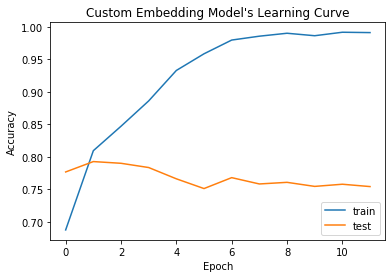

In [50]:
plt.plot(embed_dnn_history.history['accuracy'])
plt.plot(embed_dnn_history.history['val_accuracy'])
plt.title("Custom Embedding Model's Learning Curve")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='lower right')

In [51]:
embed_dnn_model.layers[0].get_weights()[0]

array([[ 4.5061419e-03, -3.4585455e-03,  5.8500189e-03, ...,
        -1.2488905e-03,  3.3553890e-03,  1.2057030e-03],
       [-1.4115256e-05,  5.6882359e-02,  4.1942779e-02, ...,
        -5.0195694e-02, -4.9790334e-02, -3.6120798e-02],
       [-5.1997166e-02, -5.1464655e-02,  1.2043651e-02, ...,
         9.5250860e-02,  5.0843794e-02,  2.2141786e-02],
       ...,
       [ 3.3902127e-02,  1.1910062e-02,  1.1071444e-02, ...,
         5.8054436e-02, -8.4683988e-03, -4.0976010e-02],
       [ 1.0858649e-01,  3.9711561e-02,  5.3277463e-02, ...,
         6.2926195e-04, -1.3095191e-02,  7.6091371e-02],
       [ 2.6002172e-02, -1.3061307e-02,  1.8642653e-02, ...,
         4.2984020e-02,  1.8953968e-02,  3.6360804e-02]], dtype=float32)

# Using Pretrained Embedding Layers

### 50-Dimentional Layer

In [52]:
dim50_model = keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1",
                   dtype=tf.string, input_shape=[], output_shape=[50]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])
dim50_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
dim50_model.fit(X_train['review_body'], y_train, validation_split=0.3, epochs=10)
y_predict = dim50_model.predict_classes(X_test['review_body'])
scores(y_test, y_predict)

Train on 16800 samples, validate on 7200 samples
Epoch 1/10
16800/16800 [==============================] - 98s 6ms/sample - loss: 0.5821 - accuracy: 0.6953 - val_loss: 0.5538 - val_accuracy: 0.7233
Epoch 2/10
16800/16800 [==============================] - 98s 6ms/sample - loss: 0.5459 - accuracy: 0.7237 - val_loss: 0.5568 - val_accuracy: 0.7211
Epoch 3/10
16800/16800 [==============================] - 98s 6ms/sample - loss: 0.5410 - accuracy: 0.7293 - val_loss: 0.5472 - val_accuracy: 0.7272
Epoch 4/10
16800/16800 [==============================] - 97s 6ms/sample - loss: 0.5382 - accuracy: 0.7307 - val_loss: 0.5453 - val_accuracy: 0.7306
Epoch 5/10
16800/16800 [==============================] - 97s 6ms/sample - loss: 0.5349 - accuracy: 0.7320 - val_loss: 0.5448 - val_accuracy: 0.7301
Epoch 6/10
16800/16800 [==============================] - 98s 6ms/sample - loss: 0.5330 - accuracy: 0.7339 - val_loss: 0.5434 - val_accuracy: 0.7314
Epoch 7/10
16800/16800 [==============================] -

### 128-Dimentional Layer

In [53]:
dim128_model = keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", output_shape=[128],
                   input_shape=[], dtype=tf.string),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])
dim128_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

dim128_model.fit(X_train['review_body'], y_train, validation_split=0.3, epochs=10)
y_predict = dim128_model.predict_classes(X_test['review_body'])
scores(y_test, y_predict)

Train on 16800 samples, validate on 7200 samples
Epoch 1/10
16800/16800 [==============================] - 331s 20ms/sample - loss: 0.5567 - accuracy: 0.7171 - val_loss: 0.5225 - val_accuracy: 0.7478
Epoch 2/10
16800/16800 [==============================] - 261s 16ms/sample - loss: 0.5116 - accuracy: 0.7577 - val_loss: 0.5244 - val_accuracy: 0.7471
Epoch 3/10
16800/16800 [==============================] - 257s 15ms/sample - loss: 0.5017 - accuracy: 0.7624 - val_loss: 0.5062 - val_accuracy: 0.7624
Epoch 4/10
16800/16800 [==============================] - 261s 16ms/sample - loss: 0.4970 - accuracy: 0.7640 - val_loss: 0.5022 - val_accuracy: 0.7638
Epoch 5/10
16800/16800 [==============================] - 262s 16ms/sample - loss: 0.4914 - accuracy: 0.7674 - val_loss: 0.5024 - val_accuracy: 0.7642
Epoch 6/10
16800/16800 [==============================] - 372s 22ms/sample - loss: 0.4877 - accuracy: 0.7689 - val_loss: 0.4977 - val_accuracy: 0.7679
Epoch 7/10
16800/16800 [=====================

# Making Predictions

In [54]:
print(X_test.review_body.iloc[0])
test = padded_test[0].reshape(1,-1)
print('\nPredicted probability:', embed_dnn_model.predict(test))
print('\nPredicted class:', embed_dnn_model.predict_classes(test))

before you buy this awful product check out warranty it only 0 days nomad business plan sell expensive piece equipment that most definitely fail after 0 usually before 0 days so that unwary buyer then pay exbortitant fee replace something that should not broken in first place should under warranty if it our first nomad drive crashed in one week second lasted about 0 months our experience here far from unique when customer service wanted charge us 0 0 repair we took high road bought ipod we also shipped dead unit company president who apparently content with his dupe consumer program caveat emptor

Predicted probability: [[0.16460235]]

Predicted class: [[0]]


In [55]:
print(X_test.review_body.iloc[1])
test = padded_test[1].reshape(1,-1)
print('\nPredicted probability:', embed_dnn_model.predict(test))
print('\nPredicted class:', embed_dnn_model.predict_classes(test))

these cases not suitable replace broken clear jewel cases because there area ridges along left side that obscures artwork tray where cd sits made frosted plastic which also obscures artwork jewel cases i received not same as those pictured in amazon listing they also made very thin plastic feel flimsy they definitely not superior in quality manufactured designed exceed industry standards as amazon listing states

Predicted probability: [[0.8584746]]

Predicted class: [[1]]


# Code References

Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition - Geron, Aurelien

https://www.linkedin.com/learning/nlp-with-python-for-machine-learning-essential-training

https://medium.com/@morga046/multi-class-text-classification-with-doc2vec-and-t-sne-a-full-tutorial-55eb24fc40d3

https://towardsdatascience.com/collocations-in-nlp-using-nltk-library-2541002998db
